# Segmentez des clients d'un site e-commerce

- **Projet 5 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 3 : Simulation de la stabilité des segments au cours du temps

<img  width="76" height="30" src="https://olist.com/wp-custom/themes/olist20/assets/img/brand.svg" alt="Logo olist">


## 1.2 Rappel de la mission

[Olist](https://olist.com/), une entreprise brésilienne qui propose une solution de vente sur les
marketplaces en ligne, souhaite une **segmentation des clients** que ses équipes d'e-commerce pourront
utiliser au quotidien pour leurs campagnes de communication.

- **comprendre les différents types d'utilisateurs**, grâce à leur comportement et à leurs données
  personnelles, en regroupant des clients de profils similaires. Ces catégories pourront être
  utilisées par l’équipe Marketing pour mieux communiquer.

- **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique
  sous-jacente pour une utilisation optimale

- **une proposition de contrat de maintenance**, (fréquence à laquelle la segmentation doit être
  mise à jour pour rester pertinente), basée sur une analyse de la stabilité des segments au cours
  du temps.


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# decommentarise la ligne suivant pour des versions testées:

# %pip install -r requirements.txt


In [2]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas', 'matplotlib', 'seaborn',
                      'scipy', 'scikit-learn', 'statsmodels',
                      'missingno', 'dython', 'squarify', 'yellowbrick', 'plotly'}
install_libraries(required_libraries)


### 1.2.1 Import des bibliothèques


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import missingno as msno
import sklearn
import dython
import squarify
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; scipy==1.7.3; missingno==0.5.0; sklearn==1.0.2; dython==0.6.8


### 1.2.3 Configuration défauts d'affichage


In [5]:
from sklearn import set_config
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab10")

set_config(display='diagram')
# displays HTML representation in a jupyter context

# Set random_state pour réproduire les resultats
# Pour des resultats différents sur chaque execution, set RANDOM_STATE=None

RANDOM_STATE = 0


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [6]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/notebook'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [7]:
def to_png(fig_name=None) -> None:
    """
    Enregistre l'image dans un fichier,
    il faut appeler avant plt.show() pour pouvoir ajuster la taille de l'image
    avec bbox_inches=tight pour être sûr d'inclure le titre / legend entier.
    """

    def get_title():
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(':', '-').replace(
            '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [8]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


### 1.3.3 Constants


In [9]:
CLUSTER_COL='cluster_id'

# 2. Evaluation de la stabilité

- L’objectif est de déterminer au bout de **combien de temps**

  - le modèle de clustering entraîné initialement proposé (donc « fit ») devient obsolète
  - (quand les prédictions, « predict », ne sont plus pertinentes),
  - nécessitant d’entraîner un nouveau modèle de clustering.

- Il s’agit de comparer

  - les numéros de clusters à t1 du fichier F1, selon que l’on utilise le modèle initial créé à
    t0(M0) via un « predict », ou le modèle créé à t1 via un « fit ».

- Il s’agit donc :
  - de simuler plusieurs périodes t1, T2 à Tt, et
  - d’afficher l’évolution de l’ARI.
- Si l’ARI passe en dessous de 0.8 (correspond environ à 0,9 en accuracy)
  - il est sûrement pertinent de reproposer un entraînement de modèle au client.


### Step 1: Les périods de temps


In [10]:
OUT_DIR = 'data/out'
df_clients = pd.read_csv(f'{OUT_DIR}/clients.csv')
df_clients.head()


,customer_unique_id,dernier_achat,Frequency,MonetaryValue,Recency,mean_nb_payments,review_score,delivery_time,delivery_delay,distance_customer_seller,freight_percent,payment_mode,favourite_category,time_of_day,weekday,products_per_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,141.90,160,8.00,5.00,6.00,-4.00,110.59,0.08,credit_card,bed_bath,10.00,3.00,1.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,27.19,163,1.00,4.00,3.00,-4.00,22.19,0.30,credit_card,health_parfum,11.00,0.00,1.00
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,86.22,585,8.00,3.00,25.00,-2.00,516.69,0.20,credit_card,office_tech,21.00,4.00,1.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,43.62,369,4.00,4.00,20.00,-11.00,2480.13,0.40,credit_card,office_tech,20.00,3.00,1.00
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,196.89,336,6.00,5.00,13.00,-7.00,154.40,0.09,credit_card,office_tech,19.00,1.00,1.00


In [11]:
print(df_clients['dernier_achat'].min())
print(df_clients['dernier_achat'].max())
print(df_clients['dernier_achat'].dtype)


2016-10-03 16:56:50
2018-08-29 15:00:37
object


In [12]:
df_clients['dernier_achat'] = pd.to_datetime(df_clients['dernier_achat'])
print(df_clients['dernier_achat'].dtype)


datetime64[ns]


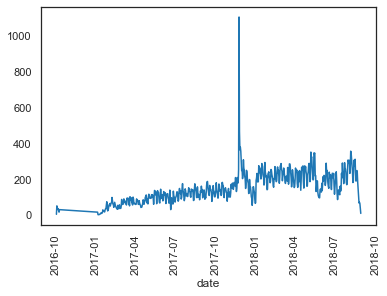

In [13]:
df_clients['date'] = df_clients['dernier_achat'].dt.date
df_clients.groupby('date')['customer_unique_id'].count().plot(kind='line')
plt.xticks(rotation=90)
plt.show()


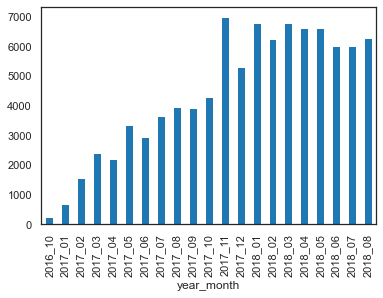

In [14]:
df_clients['year_month'] = df_clients['dernier_achat'].dt.strftime('%Y_%m')
df_clients.groupby('year_month')['customer_unique_id'].count().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

Les données entières sont disponibles pour 18 mois, du 01/01/2017 à 01/08/2018 (données avant janvier 2017 sont trop éparses; données d'aout 2018 ne sont pas complets car il y a les achats pas encore livrés)

On va comparer des prévisions basé sur 12 mois de données, pour minimiser les fluctuations sasonales

Pour éviter l'influence des outliers sur les prévisions, on va utiliser l'isolation forest pour les éxclure de fit de clustering.



## Evaluation de **la stabilité des clusters**

Pour la stabilité des clusters, on va comparer les _**fitted clusters à t(0)**_ de **données t0: de 01/08/2017 à 01/08/2018** avec les _**fitted clusters à t(N mois)**_ des données annuelles à 1, 3 ou 6 mois posterieurs:

- **predict_t0** = model_t0.fit(t0).labels_ : clusters à 01/02/2018 (basé sur 12 mois de **données t6 de 01/02/2017 à 01/02/2018**)
- **predict_t1** = model_t1.fit(t1).labels_ : clusters à 01/03/2018 (basé sur 12 mois de **données t1 de 01/03/2017 à 01/03/2018**)
- **predict_t3** = model_t3.fit(t3).labels_ : clusters à 01/05/2018 (basé sur 12 mois de **données t3 de 01/05/2017 à 01/05/2018**)
- **predict_t6** = model_t6.fit(t6).labels_ : clusters à 01/08/2018 (basé sur 12 mois de **données t6 de 01/08/2017 à 01/08/2018**)


#### Set index to customer_unique_id


In [15]:
df_clients = df_clients.set_index('customer_unique_id')


In [16]:
from datetime import datetime
# t0
START_DATE: datetime = pd.to_datetime('01/02/2017', format='%d/%m/%Y')

def one_year_dataset(df, start_date=START_DATE, nom_col='t0', date_col='dernier_achat'):
    end_date = start_date.replace(year=start_date.year+1)
    # print(f'data from {start_date:%d-%m-%Y} to {end_date:%d-%m-%Y}')
    df=df.copy()
    df[nom_col] = ((df[date_col] > start_date) & (df[date_col] < end_date))
    return df

dates={}
for i in range(0,7):
    dates[f't{i}']=START_DATE+ pd.DateOffset(months=i)

for key in dates:
    print(f'{key} : {dates[key]:%d-%m-%Y}')


t0 : 01-02-2017
t1 : 01-03-2017
t2 : 01-04-2017
t3 : 01-05-2017
t4 : 01-06-2017
t5 : 01-07-2017
t6 : 01-08-2017


In [41]:
def create_date_filter_columns(df,startdates:dict=dates):
    df=df.copy()
    for key in startdates:
        df=df.pipe(one_year_dataset,startdates[key],key)
        dmin=df[df[key]]['dernier_achat'].min()
        dmax=df[df[key]]['dernier_achat'].max()
        print (f'{key} : from {dmin:%d-%m-%Y} to {dmax:%d-%m-%Y}')
    return df

df_clients= df_clients.pipe(create_date_filter_columns)

selected_cols=['dernier_achat', *dates.keys()]

df_clients[selected_cols].head()

t0 : from 01-02-2017 to 31-01-2018
t1 : from 01-03-2017 to 28-02-2018
t2 : from 01-04-2017 to 31-03-2018
t3 : from 01-05-2017 to 30-04-2018
t4 : from 01-06-2017 to 31-05-2018
t5 : from 01-07-2017 to 30-06-2018
t6 : from 01-08-2017 to 31-07-2018


,dernier_achat,t0,t1,t2,t3,t4,t5,t6
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,False,False,False,False,True,True,True
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,False,False,False,False,True,True,True
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,True,True,False,False,False,False,False
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,True,True,True,True,True,True,True
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,True,True,True,True,True,True,True


In [18]:
date_cols=[*dates.keys()]
df_clients[date_cols].sum()

t0    47286
t1    51964
t2    56334
t3    60756
t4    64027
t5    67076
t6    69449
dtype: int64

In [19]:
df_t0=df_clients[df_clients['t0']]
df_t1=df_clients[df_clients['t1']]
df_t0_t1=df_clients[df_clients['t0']&df_clients['t1']]
print (len(df_clients))
print (len(df_t0))
print (len(df_t1))
print (len(df_t0_t1))

92732
47286
51964
45723


### Création de datasets séparés

Pour faciliter l'évaluation de performance de chaque model, et pour lisibilité du code, on crée un copie de chaque dataset

In [20]:
def factory_one_year_dataset(df, start_date=START_DATE, date_col='dernier_achat'):
    end_date = start_date.replace(year=start_date.year+1)
    # print(f'data from {start_date:%d-%m-%Y} to {end_date:%d-%m-%Y}')
    return df[(df[date_col] > start_date) & (df[date_col] < end_date)]


df_t0 = factory_one_year_dataset(df_clients, START_DATE)
print(f't0.shape : {df_t0.shape}')
df_t1 = factory_one_year_dataset(df_clients, START_DATE + pd.DateOffset(months=1))
print(f't1.shape : {df_t1.shape}')
df_t2 = factory_one_year_dataset(df_clients, START_DATE + pd.DateOffset(months=2))
print(f't1.shape : {df_t2.shape}')
df_t3 = factory_one_year_dataset(df_clients, START_DATE + pd.DateOffset(months=3))
print(f't3.shape : {df_t3.shape}')
df_t4 = factory_one_year_dataset(df_clients, START_DATE + pd.DateOffset(months=4))
print(f't5.shape : {df_t4.shape}')
df_t5 = factory_one_year_dataset(df_clients, START_DATE + pd.DateOffset(months=5))
print(f't5.shape : {df_t5.shape}')
df_t6 = factory_one_year_dataset(df_clients, START_DATE + pd.DateOffset(months=6))
print(f't6.shape : {df_t6.shape}')


t0.shape : (47286, 24)
t1.shape : (51964, 24)
t1.shape : (56334, 24)
t3.shape : (60756, 24)
t5.shape : (64027, 24)
t5.shape : (67076, 24)
t6.shape : (69449, 24)


#### Nombre de clients commun entre les datasets


In [21]:
df_clients_communs=pd.DataFrame.from_dict({
    't0':len(df_t0),
    't0_t1':len(df_t0.index.intersection(df_t1.index)),
    't0_t2':len(df_t0.index.intersection(df_t2.index)),
    't0_t3':len(df_t0.index.intersection(df_t3.index)),
    't0_t4':len(df_t0.index.intersection(df_t4.index)),
    't0_t5':len(df_t0.index.intersection(df_t5.index)),
    't0_t6':len(df_t0.index.intersection(df_t6.index))
}, orient='index', columns={'clients_communs'})
df_clients_communs.style.bar(vmin=0)

,clients_communs
t0,47286
t0_t1,45723
t0_t2,43320
t0_t3,41138
t0_t4,37811
t0_t5,34869
t0_t6,31219


In [22]:
def en_commun(df,date_cols=dates.keys()):
    intersect={}
    for col in date_cols:
        intersect[f't0_{col}']=(df['t0']&df[col]).sum()
    return pd.DataFrame.from_dict(intersect, orient='index', columns={'clients_communs'})

en_commun(df_clients).style.bar(vmin=0)

,clients_communs
t0_t0,47286
t0_t1,45723
t0_t2,43320
t0_t3,41138
t0_t4,37811
t0_t5,34869
t0_t6,31219


### Procedures pour éliminer les outliers


In [23]:
from sklearn.ensemble import IsolationForest


def find_outliers(df, num_cols=None, alpha=0.005, random_state=RANDOM_STATE):
    df = df.copy()
    if num_cols is None:
        num_cols = df.select_dtypes('number').columns
    model = IsolationForest(contamination=alpha, random_state=random_state)
    model.fit(df[num_cols].values)
    # outliers=model.predict(df[num_cols]<0)
    # enregistre comme une colonne non-numérique
    df['outlier'] = np.where(model.predict(
        df[num_cols].values) < 0, 'yes', 'no')
    return df


def drop_outliers(df):
    if 'outlier' in df.columns:
        return df[~(df['outlier'] == 'yes')].drop('outlier', axis=1)
    return df


print(df_t0.shape)
print(df_clients[df_clients['t0']].shape)
df_t0.pipe(find_outliers).pipe(drop_outliers).shape


(47286, 24)
(47286, 24)


(47049, 24)

## Pipeline pour model


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans

model = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(output_distribution='normal')),
    ('clf', KMeans(n_clusters=7, random_state=RANDOM_STATE))
])


In [25]:
from copy import deepcopy
FEATURES = ['Frequency', 'MonetaryValue',
            'review_score', 'mean_nb_payments', 'delivery_delay']


def run_fit_model(df, model_, features=FEATURES, k=7, cluster_col=CLUSTER_COL,
                  remove_outliers_during_fit=True, percent_outliers=0.005,
                  random_state=RANDOM_STATE):
    df = df.copy()
    
    params = {'clf__n_clusters': k}
    model_.set_params(**params)
    
    if percent_outliers<=0:
        remove_outliers_during_fit=False
    if remove_outliers_during_fit:
        df = df.pipe(find_outliers, num_cols=features,
                     alpha=percent_outliers, random_state=random_state)
        df_outliers = df[df['outlier'] == 'yes']
        df = df[df['outlier'] != 'yes']


    model_.fit(df[features])
    clf = model_.named_steps['clf']
    df[cluster_col] = clf.labels_


    if remove_outliers_during_fit:
        # si les outliers ont été exclu du fit, il faut maintenant les ajoutés de retour au model
        df_outliers[cluster_col] = model_.predict(df_outliers[features])
        df = df.append(df_outliers, ignore_index=False)

    return df, deepcopy(model_)


def run_predict_model(df, fitted_model, features=FEATURES, cluster_col=CLUSTER_COL):
    df = df.copy()
    df[cluster_col] = fitted_model.predict(df[features])
    return df


## Fit sur model à t0 (clusters basé sur les données t0)
On veut savoir comment les prédictions basé sur model t0 changent dans le temps

Donc on veut comparer:
- les clusters a t0 : 01/02/2018
- les clusters à t1 (1 mois après) vs. clusters prévus par t0
- les clusters à t3 (3 mois après) vs. clusters prévus par t0
- les clusters à t6 (6 mois après) vs. clusters prévus par t0


In [39]:
K=7
# fit tN clusters based on data at t0
fit_t0, fitted_model_t0 = run_fit_model(df_t0, model, FEATURES, k=K)
# predict t0 clusters based on (old) model at t0
predict_t0 = run_predict_model(df_t0, fitted_model_t0, FEATURES)

# fit t1 clusters based on data at t1
fit_t1, fitted_model_t1 = run_fit_model(df_t1, model, FEATURES, k=K)
# predict t1 clusters based on (old) model at t0
predict_t1 = run_predict_model(df_t1, fitted_model_t0, FEATURES)

# fit t2 clusters based on data at t2
fit_t2, fitted_model_t2 = run_fit_model(df_t2, model, FEATURES, k=K)
# predict t2 clusters based on (old) model at t0
predict_t2 = run_predict_model(df_t2, fitted_model_t0, FEATURES)

# fit t3 clusters based on data at t3
fit_t3, fitted_model_t3 = run_fit_model(df_t3, model, FEATURES, k=K)
# predict t3 clusters based on (old) model at t0
predict_t3 = run_predict_model(df_t3, fitted_model_t0, FEATURES)

# fit t4 clusters based on data at t4
fit_t4, fitted_model_t4 = run_fit_model(df_t4, model, FEATURES, k=K)
# predict t4 clusters based on (old) model at t0
predict_t4 = run_predict_model(df_t4, fitted_model_t0, FEATURES)

# fit t5 clusters based on data at t5
fit_t5, fitted_model_t5 = run_fit_model(df_t5, model, FEATURES, k=K)
# predict t5 clusters based on (old) model at t0
predict_t5 = run_predict_model(df_t5, fitted_model_t0, FEATURES)

# fit t3 clusters based on data at t6
fit_t6, fitted_model_t6 = run_fit_model(df_t6, model, FEATURES, k=K)
# predict t6 clusters based on (old) model at t0
predict_t6 = run_predict_model(df_t6, fitted_model_t0, FEATURES)


print(df_t0.shape)
# fit_t0 on ajoute les colonnes 'cluster_id' et 'outlier' (indicateur = ['yes'|'no'])
print(fit_t0.shape)
# predict_t1 on ajoute la colonne 'cluster_id'
print(predict_t0.shape)


(47286, 24)
(47286, 26)
(47286, 25)


In [27]:
def fit_sur_model_t0(df, k=7):

    # select t0 data
    df_t0=df[df['t0']]
    # fit tN clusters based on data at t0
    fit_t0, fitted_model_t0 = run_fit_model(df_t0, model, FEATURES, k=K)
    df=df.join(fit_t0[[CLUSTER_COL]],rsuffix='_fit_t0')

    # select t1 data
    df_t1=df[df['t1']]
    # fit t1 clusters based on data at t1
    fit_t1, fitted_model_t1 = run_fit_model(df_t1, model, FEATURES, k=K)
    df=df.join(fit_t1[[CLUSTER_COL]],rsuffix='_fit_t1')
    # predict t1 clusters based on (old) model at t0
    predict_t1 = run_predict_model(df_t1, fitted_model_t0, FEATURES)
    df=df.join(predict_t1[[CLUSTER_COL]],rsuffix='_predict_t1')

    # repeat for other data
    for i in range(1,6): 
        # select t1 data
        df_ti=df[df[f't{i}']]
        # fit t{i} clusters based on data at t{i}
        fit_ti, fitted_model_ti = run_fit_model(df_ti, model, FEATURES, k=K)
        df=df.join(fit_ti[[CLUSTER_COL]],rsuffix=f'_fit_t{i}')
        # predict t{i} clusters based on (old) model at t0
        predict_ti = run_predict_model(df_ti, fitted_model_t0, FEATURES)
        df=df.join(predict_ti[[CLUSTER_COL]],rsuffix='_predict_t{i}')
        return df

df_clients2=df_clients.pipe(fit_sur_model_t0,k=7)


print(df_t0.shape)
# fit_t0 on ajoute les colonnes 'cluster_id' et 'outlier' (indicateur = ['yes'|'no'])
print(fit_t0.shape)
# predict_t1 on ajoute la colonne 'cluster_id'
print(predict_t1.shape)


(47286, 24)
(47286, 26)
(51964, 25)


In [28]:
fit_t0.tail()


,dernier_achat,Frequency,MonetaryValue,Recency,mean_nb_payments,review_score,delivery_time,delivery_delay,distance_customer_seller,freight_percent,payment_mode,favourite_category,time_of_day,weekday,products_per_order,date,year_month,t0,t1,t2,t3,t4,t5,t6,outlier,cluster_id
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,
fc54c2c09aee36da48881e5bf37ef795,2017-12-15 13:43:13,1,2732.06,305,10.00,4.00,6.00,-19.00,534.93,0.01,credit_card,office_tech,13.00,4.00,2.00,2017-12-15,2017_12,True,True,True,True,True,True,True,yes,3
fd9d39fa11a8725fabb15d0ff706251c,2017-04-04 11:26:31,1,764.52,561,10.00,1.00,44.00,11.00,2177.50,0.03,credit_card,gifts_gadgets,11.00,1.00,1.00,2017-04-04,2017_04,True,True,True,False,False,False,False,yes,5
ff0ae98646e7bbb41cf0f0d3991fef98,2017-06-05 20:52:34,1,3048.27,498,10.00,5.00,10.00,-20.00,1084.39,0.02,credit_card,office_tech,20.00,0.00,1.00,2017-06-05,2017_06,True,True,True,True,True,False,False,yes,2
ff4159b92c40ebe40454e3e6a7c35ed6,2017-05-24 18:14:34,1,6726.66,510,1.00,5.00,11.00,-23.00,616.35,0.03,boleto,leisure,18.00,2.00,1.00,2017-05-24,2017_05,True,True,True,True,False,False,False,yes,0
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,1,2067.42,495,10.00,5.00,27.00,-27.00,1995.22,0.12,credit_card,health_parfum,21.00,3.00,2.00,2017-06-08,2017_06,True,True,True,True,True,False,False,yes,2


### Taille des clusters

In [40]:
def cluster_sizes(df,cluster_col=CLUSTER_COL, normalize=True):
    if normalize:
        return (df[cluster_col].value_counts(normalize=True).values*100).astype(int)
    else:
        return df[cluster_col].value_counts(normalize=False).values

print(cluster_sizes(fit_t0))
print(cluster_sizes(predict_t0))
print(cluster_sizes(fit_t1))
print(cluster_sizes(predict_t1))
print(cluster_sizes(fit_t2))
print(cluster_sizes(predict_t2))
print(cluster_sizes(fit_t3))
print(cluster_sizes(predict_t3))
print(cluster_sizes(fit_t6))
print(cluster_sizes(predict_t6))


[29 27 16 14  5  4  2]
[29 27 16 14  5  4  2]
[28 27 16 14  5  4  2]
[28 27 16 14  5  4  2]
[28 26 16 15  5  4  2]
[28 26 16 15  5  4  2]
[30 24 16 14 10  1  1]
[28 27 15 15  5  4  2]
[31 25 16 13 10  1  1]
[28 28 15 14  5  4  3]


Generate list of cluster_labels

In [69]:
lbl=['cluster_id']
cid='customer_unique_id'
# pred_t0 = run_predict_model(df_t0, fitted_model_t6, FEATURES)
# pred_t1 = run_predict_model(df_t1, fitted_model_t6, FEATURES)
# pred_t3 = run_predict_model(df_t3, fitted_model_t6, FEATURES)
# pred_t6 = run_predict_model(df_t6, fitted_model_t6, FEATURES)

def in_both(df1,df2,label_col=CLUSTER_COL):
    in_both = df1.index.intersection(df2.index)
    ret= df1.loc[in_both,lbl].astype('Int64')
    ret.columns=[label_col]
    return ret

fitd_t0=in_both(fit_t0,predict_t0,'fit_t0')
pred_t0=in_both(predict_t0,fit_t0,'pred_t0')
fitd_t1=in_both(fit_t1,predict_t1,'fit_t1')
pred_t1=in_both(predict_t1,fit_t1,'pred_t1')
fitd_t3=in_both(fit_t3,predict_t3,'fit_t3')
pred_t3=in_both(predict_t3,fit_t3,'pred_t3')
fitd_t6=in_both(fit_t6,predict_t6,'fit_t6')
pred_t6=in_both(predict_t6,fit_t6,'pred_t6')

df_evolve= (df_clients[lbl].astype('Int64')
.join(fitd_t0).join(pred_t0)
.join(fitd_t1).join(pred_t1)
.join(fitd_t3).join(pred_t3)
.join(fitd_t6).join(pred_t6)
# .drop(CLUSTER_COL,axis=1)
)

df_evolve.head()

,cluster_id,fit_t0,pred_t0,fit_t1,pred_t1,fit_t3,pred_t3,fit_t6,pred_t6
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,2
0000b849f77a49e4a4ce2b2a4ca5be3f,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,1
0000f46a3911fa3c0805444483337064,3,3,3,4,3,<NA>,<NA>,<NA>,<NA>
0000f6ccb0745a6a4b88665a16c9f078,3,3,3,4,3,0,3,1,3
0004aac84e0df4da2b147fca70cf8255,2,2,2,0,2,5,2,4,2


In [60]:
# sankey nodes
labels= df_evolve['fit_t0'].unique()
periods=df_evolve.columns
print(df_evolve.columns)
print(labels)


Index(['fit_t0', 'pred_t0', 'fit_t1', 'pred_t1', 'fit_t3', 'pred_t3', 'fit_t6',
       'pred_t6'],
      dtype='object')
<IntegerArray>
[<NA>, 3, 2, 0, 5, 1, 4, 6]
Length: 8, dtype: Int64


In [67]:
print(pd.crosstab(df_evolve['fit_t0'],df_evolve['pred_t0']))


pred_t0      0     1      2     3     4     5     6
fit_t0                                             
0        12957     0      0     0     0     0     0
1            0  6992      0     0     0     0     0
2            0     0  14031     0     0     0     0
3            0     0      0  7790     0     0     0
4            0     0      0     0  1905     0     0
5            0     0      0     0     0  2384     0
6            0     0      0     0     0     0  1227


### Comparison avec données 1 mois après fit

In [70]:
print(pd.crosstab(df_evolve['fit_t1'],df_evolve['pred_t1']))


pred_t1      0     1      2     3     4     5     6
fit_t1                                             
0            0     0  15068     0     0     0     0
1            0  7763      0     0     0     0     0
2        14109     0      0     0     0     0     0
3            0     0      0     0     0  2817     0
4            0     0      0  8478     0     0     0
5            0     0      0     0  2311     0     0
6            0     0      0     0     0     0  1418


In [66]:
print(pd.crosstab(df_evolve[periods[0]],df_evolve[periods[5]]))


pred_t3      0     1      2     3     4     5     6
fit_t0                                             
0        11170     0      0     0     0     0     0
1            0  6010      0     0     0     0     0
2            0     0  12291     0     0     0     0
3            0     0      0  6765     0     0     0
4            0     0      0     0  1657     0     0
5            0     0      0     0     0  2116     0
6            0     0      0     0     0     0  1129


In [65]:
print(pd.crosstab(df_evolve[periods[6]],df_evolve[periods[7]]))




pred_t6      0     1      2     3     4     5     6
fit_t6                                             
0        16557     0   5066     0     0     0     0
1            0  8502      0  2811     0     0     0
2            0     0      0     0  3177  3882     0
3            0  1846      0  7778     0     0     0
4         3132     0  14534     0     0     0     0
5            0     0      0     0    31    43  1041
6            0     0      0     0     0     0  1049


In [ ]:
t1=df_evolve[['cluster_id','cluster_id_t1']].dropna()
# adjusted_rand_score(t1['cluster_id'], t1['cluster_id_t1'])

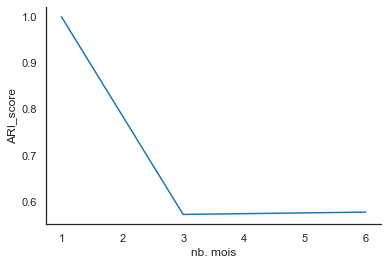

In [71]:
from sklearn.metrics import adjusted_rand_score as ari

df_ari = pd.DataFrame([], columns={'nb. mois', 'ARI_score'})
t1=df_evolve[['fit_t1','pred_t1']].dropna()
df_ari = df_ari.append({'nb. mois': 1, 'ARI_score': ari(t1['fit_t1'],t1['pred_t1'].values)}, ignore_index=True)
t3=df_evolve[['fit_t3','pred_t3']].dropna()
df_ari = df_ari.append({'nb. mois': 3, 'ARI_score': ari(t3['fit_t3'],t3['pred_t3'].values)}, ignore_index=True)
t6=df_evolve[['fit_t6','pred_t6']].dropna()
df_ari = df_ari.append({'nb. mois': 6, 'ARI_score': ari(t6['fit_t6'],t6['pred_t6'].values)}, ignore_index=True)
sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score')
sns.despine()

### Calculate ARI Scores


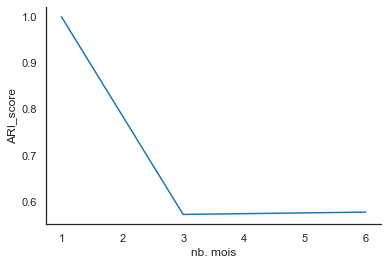

In [72]:
from sklearn.metrics import adjusted_rand_score


def calc_ari_score(df_true: pd.DataFrame, df_predicted: pd.DataFrame, cluster_col='cluster_id'):
    in_both = df_true.index.intersection(df_predicted.index)
    ari = adjusted_rand_score(
        df_true.loc[in_both, cluster_col],
        df_predicted.loc[in_both, cluster_col]
    )
    return ari


df_ari = pd.DataFrame([], columns={'nb. mois', 'ARI_score'})
df_ari = df_ari.append({'nb. mois': 1, 'ARI_score': calc_ari_score(
    fit_t1, predict_t1)}, ignore_index=True)
df_ari = df_ari.append({'nb. mois': 3, 'ARI_score': calc_ari_score(
    fit_t3, predict_t3)}, ignore_index=True)
df_ari = df_ari.append({'nb. mois': 6, 'ARI_score': calc_ari_score(
    fit_t6, predict_t6)}, ignore_index=True)
sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score')
sns.despine()


Automation pour détecter le nombre de clusters plus stable


"Sta.png"


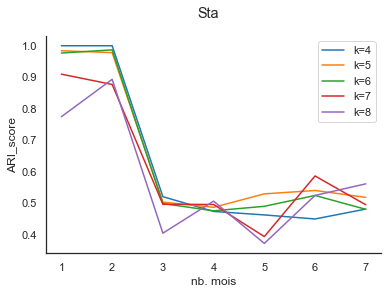

In [74]:
from time import time
model = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(output_distribution='normal',random_state=RANDOM_STATE)),
    ('clf', KMeans(n_clusters=8, random_state=RANDOM_STATE))
])


def test_stability(df, model, features=FEATURES, k=K,
                   date_col='dernier_achat', t0=START_DATE,
                   random_state=RANDOM_STATE, percent_outliers=0.5):
    """ automatisation pour détecter les clusters les plus stables"""
    df_ari = pd.DataFrame([], columns={'k','t0','n','nb. mois', 'ARI_score'})
    df_t0 = factory_one_year_dataset(df, start_date=t0, date_col=date_col)
    fit_t0, fitted_model_T0 = run_fit_model(df_t0, model, features, k=k,
                               remove_outliers_during_fit=True, percent_outliers=percent_outliers, random_state=random_state)

    for mois in range(1, 8):
        df_TN = factory_one_year_dataset(df, t0 + pd.DateOffset(months=mois))
        fit_TN, fitted_model_TN= run_fit_model(df_TN, model, features, k=k,remove_outliers_during_fit=True, percent_outliers=percent_outliers, random_state=random_state)
        predict_TN = run_predict_model(df_TN, fitted_model_T0, features)
        df_ari = df_ari.append({'k':k,'t0':f'{t0:%d%m%Y}','n':len(df_t0),'nb. mois': mois,
         'ARI_score': calc_ari_score(fit_TN, predict_TN)}, ignore_index=True)
        df_ari['k']=df_ari['k'].astype('category')

    return df_ari

start=time()
df_ari_4 =test_stability(df_clients, model,k=4)
calc_time = round((time()-start), 2)
print(f'k=4, completed in ',(time = {calc_time} s))
print('running k=5')
df_ari_5 =test_stability(df_clients, model,k=5)
df_ari_6 =test_stability(df_clients, model,k=6)
df_ari_7 =test_stability(df_clients, model,k=7)
df_ari_8 =test_stability(df_clients, model,k=8)

ax=sns.lineplot(data=df_ari_4, x='nb. mois', y='ARI_score', label='k=4')
sns.lineplot(data=df_ari_5, x='nb. mois', y='ARI_score', label='k=5', ax=ax)
sns.lineplot(data=df_ari_6, x='nb. mois', y='ARI_score', label='k=6', ax=ax)
sns.lineplot(data=df_ari_7, x='nb. mois', y='ARI_score', label='k=7', ax=ax)
sns.lineplot(data=df_ari_8, x='nb. mois', y='ARI_score', label='k=8', ax=ax)
sns.despine()
plt.suptitle('Sta')
to_png()


In [ ]:
def test_clusters_stability(df,model,k_range=range(4,9),t0=START_DATE, percent_outliers=0.005,random_state=RANDOM_STATE):
    """test pour plusieurs valeurs de taille des clusters """
    scores=pd.DataFrame([])
    for k in k_range:
        df_ari=test_stability(df,model,k=k,t0=t0, percent_outliers=percent_outliers, random_state=random_state)
        df_ari['k']=k
        ari_scores =list(np.round(df_ari['ARI_score'],2))
        print(f'k={k}; ARI_scores={ari_scores}')
        scores=scores.append(df_ari, ignore_index=True)
    scores['k']=scores['k'].astype('category')

    return scores
 
df_ari =test_clusters_stability(df_clients, model,k_range=[4],percent_outliers=0.005)



In [ ]:
df_ari =test_clusters_stability(df_clients, model,percent_outliers=0.005)
sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score', hue='k')
sns.despine()


Test l'effet de random_state sur la stabilité des clusters

In [ ]:
df_ari =test_clusters_stability(df_clients, model,random_state=1)
sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score', hue='k')
sns.despine()
plt.suptitle('Stabilité des clusters - effet de changer random_state')
plt.title('random_state=1, percent_outliers=0.005')

In [ ]:
df_ari =test_clusters_stability(df_clients, model,random_state=None)
sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score', hue='k')
sns.despine()
plt.suptitle('Stabilité des clusters - effet sans définir random_state')
plt.title('random_state=None, percent_outliers=0.005')

Test l'effet des outliers sur la stabilité des clusters

In [ ]:
df_ari =test_clusters_stability(df_clients, model,percent_outliers=0)
sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score', hue='k')
sns.despine()
plt.suptitle('Stabilité des clusters - effet sans éliminer les outliers')
plt.title('random_state=None, percent_outliers=0.005')

In [ ]:
df_ari =test_clusters_stability(df_clients, model,percent_outliers=0.02)
sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score', hue='k')
sns.despine()
plt.suptitle('Stabilité des clusters - effet en éliminant 2% des outliers')
plt.title('random_state=None, percent_outliers=0.005')

L'influence d'élimination des outliers pendant le clustering à l'effet de:
- améliorier la stabilité des clusters pour les prédictions de 2 mois
- réduire la stabilté des clusters k=7 et k=8 pour les prédictions d'un mois

Stabilité des clusters - effet de changer la période d'évaluation

In [ ]:
START_DATE2: datetime = pd.to_datetime('23/08/2017', format='%d/%m/%Y')
df_ari =test_clusters_stability(df_clients, model,t0=START_DATE2)
sns.lineplot(data=df_ari, x='nb. mois', y='ARI_score', hue='k')
sns.despine()
plt.suptitle('Stabilité des clusters - effet de changer la date pour laquelle prédire')
plt.title(f'date={START_DATE2:%d/%m/%Y}, random_state=0, percent_outliers=0.005')
to_png()

In [ ]:
START_DATE3: datetime = pd.to_datetime('01/02/2017', format='%d/%m/%Y')
dates=[(START_DATE3+pd.DateOffset(months=i)) for i in range(0,8)]
df_ari_0 =test_stability(df_clients, model,t0=dates[0], k=7)
df_ari_1 =test_stability(df_clients, model,t0=dates[1], k=7)
df_ari_2 =test_stability(df_clients, model,t0=dates[2], k=7)
df_ari_3 =test_stability(df_clients, model,t0=dates[3], k=7)
df_ari_4 =test_stability(df_clients, model,t0=dates[4], k=7)
df_ari_5 =test_stability(df_clients, model,t0=dates[5], k=7)
df_ari_6 =test_stability(df_clients, model,t0=dates[6], k=7)
df_ari_7 =test_stability(df_clients, model,t0=dates[7], k=7)

print(df_ari_7.head())

ax=sns.lineplot(data=df_ari_0, x='nb. mois', y='ARI_score', label=f'date={dates[0]:%d-%m-%Y}')
sns.lineplot(data=df_ari_1, x='nb. mois', y='ARI_score', label=f'date={dates[1]:%d-%m-%Y}', ax=ax)
sns.lineplot(data=df_ari_2, x='nb. mois', y='ARI_score', label=f'date={dates[2]:%d-%m-%Y}', ax=ax)
sns.lineplot(data=df_ari_3, x='nb. mois', y='ARI_score', label=f'date={dates[3]:%d-%m-%Y}', ax=ax)
sns.lineplot(data=df_ari_4, x='nb. mois', y='ARI_score', label=f'date={dates[4]:%d-%m/%Y}', ax=ax)
sns.lineplot(data=df_ari_5, x='nb. mois', y='ARI_score', label=f'date={dates[5]:%d-%m-%Y}', ax=ax)
sns.lineplot(data=df_ari_6, x='nb. mois', y='ARI_score', label=f'date={dates[6]:%d-%m-%Y}', ax=ax)
sns.lineplot(data=df_ari_7, x='nb. mois', y='ARI_score', label=f'date={dates[7]:%d-%m-%Y}', ax=ax)
sns.despine()
plt.legend(title='12-month end date', bbox_to_anchor=(1.5, 0.5), loc=5)
plt.suptitle('Cluster stability (k=7) : effect of changing 12-month prediction period dates')
plt.title(f'date={START_DATE3:%d/%m/%Y}, random_state=0, percent_outliers=0.005')
to_png()

On voit que les prédictions des 7 clusters pour les mois 01/2018 à 04/2018 sont stables,
Les prédictions pour le mois de 08/2018 semble stable à 2 mois
Par contre, les prédictions pour les mois de 05/2018 à 07/2018 semble pas stable. 


In [ ]:
START_DATE3: datetime = pd.to_datetime('01/02/2017', format='%d/%m/%Y')
dates=[(START_DATE3+pd.DateOffset(months=i)) for i in range(0,8)]
df_ari_0 =test_stability(df_clients, model,t0=dates[0], k=5)
df_ari_1 =test_stability(df_clients, model,t0=dates[1], k=5)
df_ari_2 =test_stability(df_clients, model,t0=dates[2], k=5)
df_ari_3 =test_stability(df_clients, model,t0=dates[3], k=5)
df_ari_4 =test_stability(df_clients, model,t0=dates[4], k=5)
df_ari_5 =test_stability(df_clients, model,t0=dates[5], k=5)
df_ari_6 =test_stability(df_clients, model,t0=dates[6], k=5)
df_ari_7 =test_stability(df_clients, model,t0=dates[7], k=5)

print(df_ari_7.head())

ax=sns.lineplot(data=df_ari_0, x='nb. mois', y='ARI_score', label=f'date={dates[0]:%d/%m/%Y}')
sns.lineplot(data=df_ari_1, x='nb. mois', y='ARI_score', label=f'date={dates[1]:%d/%m/%Y}', ax=ax)
sns.lineplot(data=df_ari_2, x='nb. mois', y='ARI_score', label=f'date={dates[2]:%d/%m/%Y}', ax=ax)
sns.lineplot(data=df_ari_3, x='nb. mois', y='ARI_score', label=f'date={dates[3]:%d/%m/%Y}', ax=ax)
sns.lineplot(data=df_ari_4, x='nb. mois', y='ARI_score', label=f'date={dates[4]:%d/%m/%Y}', ax=ax)
sns.lineplot(data=df_ari_5, x='nb. mois', y='ARI_score', label=f'date={dates[5]:%d/%m/%Y}', ax=ax)
sns.lineplot(data=df_ari_6, x='nb. mois', y='ARI_score', label=f'date={dates[6]:%d/%m/%Y}', ax=ax)
sns.lineplot(data=df_ari_7, x='nb. mois', y='ARI_score', label=f'date={dates[7]:%d/%m/%Y}', ax=ax)
sns.despine()
plt.legend(title='12-month end date', bbox_to_anchor=(1.5, 0.5), loc=5)
plt.suptitle('')

## Choix de périod de maintenance

On choisi le nombre de clusters egal à 7, et les clusters de reference celles de janvier 2018

In [ ]:
df_t0.head()

### Evaluation de **la stabilité des prédictions**

Pour la stabilité des prédictions, on va comparer les clusters _**fitted clusters à t(6)**_ de **données t0: de 01/08/2017 à 01/08/2018** avec les _**prédictions**_ de clusters bases sur les modeles de 1, 3 et 6 mois antérieurs:

- **predict_t6** = model.fit(t6).predict(t6) : clusters à 01/08/2018 (basé sur **données t6 de 01/08/2017 à 01/08/2018**)
- **predict_t6_1** = model.fit(t5).predict(t6) : les prédictions pour le cluster de chaque client à t6, fait avec les clusters fitted 1 mois avant : **model_t5 - des données T5 = du 01/07/2017 à 01/07/2018**
- **predict_t6_3** = model.fit(t3).predict(t6) : les prédictions pour le cluster de chaque client à t6, fait avec les clusters fitted 3 mois avant : **des données t3 = du 01/05/2017 à 01/05/2018**
- **predict_t6_6** = model.fit(t0).predict(t6) :les prédictions pour le cluster de chaque client à t6, fait avec les clusters fitted 6 mois avant : **des données t1 = du 01/02/2017 à 01/02/2018**

#### Nombre de clients commun entre les datasets


In [ ]:
print(len(df_t0.index.intersection(df_t1.index)))
print(len(df_t0.index.intersection(df_t3.index)))
print(len(df_t0.index.intersection(df_t6.index)))


In [ ]:
K = 7
# predict t0 clusters based on data at t0
true_t0, fitted_model_t0 = run_fit_model(df_t0, model, FEATURES, k=K)

fit_t1, fitted_model_t1 = run_fit_model(df_t1, model, FEATURES, k=K)
# predict t0 clusters based on data at t1
predict_t1 = run_predict_model(df_t0, fitted_model_t1, FEATURES)

fit_t3, fitted_model_t3 = run_fit_model(df_t3, model, FEATURES, k=K)
# predict t0 clusters based on data at t3
predict_t3 = run_predict_model(df_t0, fitted_model_t3, FEATURES)

fit_t6, fitted_model_t6 = run_fit_model(df_t6, model, FEATURES, k=K)
# predict t0 clusters based on data at t6
predict_t6 = run_predict_model(df_t0, fitted_model_t6, FEATURES)



print(df_t0.shape)
# true_t0 on ajoute les colonnes 'cluster_id' et 'outlier' (indicateur = ['yes'|'no'])
print(true_t0.shape)
# predict_t1 on ajoute la colonne 'cluster_id'
print(predict_t1.shape)
